<a href="https://colab.research.google.com/github/srilamaiti/spring_2023_w266_final_project_heesuk_iris_srila/blob/main/heesuk/W266_Regression_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Update the version of tensorflow to 2.11.0**

In [ ]:
!pip uninstall tensorflow              # uninstall the current version of tf that Colab automatically installs
!pip install tensorflow==2.11.0        # install 2.11.0 version, which the model worked at that point with a GPU
# Next step: go to "Runtime" and "Restart runtime"
# then confirm if the version is properly updated to 2.11.0 by running the followin print statement - "import tensorflow as tf | print(tf.__version__)"

# Check the version of tensorflow

In [ ]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

# Install New Libraries

In [ ]:
!pip install nltk
!pip install wordcloud
!pip install transformers

# **Importing Libraries**

In [ ]:
import random

#NLP related libraries
import transformers
print(f'transformers version: {transformers.__version__}')
from transformers import logging as hf_logging
from transformers import BertTokenizer, TFBertModel
hf_logging.set_verbosity_error()
import nltk
from nltk.tokenize import sent_tokenize
import spacy      
from spacy import displacy
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
from sklearn.model_selection import train_test_split
nltk.download('punkt')

# Other required libraries
import os
import pandas as pd
pd.set_option('display.width', 180)    # increase pandas display output in Colab
import numpy as np
import re
import copy
import sys
import datetime
import time
from keras.utils.layer_utils import count_params
import locale
locale.getpreferredencoding = lambda: "UTF-8"
import warnings
warnings.filterwarnings("ignore")
# import logging
# logging.getLogger().setLevel(logging.NOTSET)

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow libraries
import tensorflow as tf
# tf.keras.backend.set_floatx('float16')
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import load_model

from google.colab import drive
drive.mount('/content/gdrive')

# **General Functions**

## **Set Config Parameters**

In [ ]:
def set_config_param(seed = 99):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_columns', None)
    
    
set_config_param(20230214)

## **Count Plot**

In [ ]:
# def plot_count(df, labels):
#   sns.set_style('whitegrid')
#   plt.figure(figsize=(18,10))
#   for idx, label in enumerate(labels):
#       plt.subplot(2, 3, idx+1)
#       sns.countplot(x = label, data = df)

## **Adding Feature Columns**

In [ ]:
def add_feature(df):

    # Cleaning up full_text : Removing tabl and carriage return characters
    df['full_text'] = df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

    # Adding word count, sentence count, total score and full text length
    df['word_count'] = df['full_text'].apply(lambda x: len(x.split()))
    df['sentence_count'] = df['full_text'].apply(lambda x: len(sent_tokenize(x)))
    df['total_score'] = df['cohesion'] + df_train['syntax'] + df['vocabulary'] + df['phraseology'] + df['grammar'] + df['conventions']
    df['full_text_len'] = df['full_text'].apply(lambda x: len(x))

    # Adding mean, median score per label and indicator column 
    # whether the label value is below or above mean or median value
    for label in label_cols:
        df[label + '_avg_score'] = np.mean(df[label])
        df[label + '_above_or_below_avg_flag'] = np.where(df[label] > np.mean(df[label]), 1, 0)  
        df[label + '_median_score'] = np.median(df[label])
        df[label + '_above_or_below_median_flag'] = np.where(df[label] > np.median(df[label]), 1, 0)  
        df[label + '_rounded_val'] = np.round(df[label])  
    
    return df

## **Getting Unique Values for Each Label**

In [ ]:
# def get_unique_values_for_labels(df, col_list):
#     print('Unique Values in Each Metric:\n==================================================')
#     for col in col_list:
#         print(f'{col}: {df[col].unique()}')

## **Getting Value Counts for Each Label**

In [ ]:
# def get_value_counts_for_labels(df, col_list):
#     print('Counts for Each Metric:\n==================================================')
#     for col in col_list:
#         print(f"Column: {col}")
#         print(f'{df[col].value_counts().sort_values()}')
#         print("*****")

## **Getting Histogram for a Column**

In [ ]:
# def get_histogram_for_col(df, col_list, col_name):
#     sns.set_style('whitegrid')
#     plt.figure(figsize=(18,10))
#     for idx, label in enumerate(col_list):
#         plt.subplot(2, 3, idx+1)
#         sns.histplot(x=col_name, hue = label, data = df)
#         plt.xlabel('Word Count', fontsize=10)

## **Getting Count Plot for Indicator Columns**

In [ ]:
# def get_count_plot_for_ind_col(df, search_string, col_list):
#     fig, ax = plt.subplots(1, len(col_list), figsize=(50,10))
#     for idx, label in enumerate(col_list):
#         sns.countplot(x = df[label + search_string], ax = ax[idx])
#         ax[idx].set_title(label)

## **Getting Bar Plot for Each Label**

In [ ]:
# def get_barplot_for_each_label(df, col_list, search_string):
#     avg_score_cols = [col + search_string for col in col_list]
#     plt.figure(figsize=(8,5))
#     ax = sns.barplot(x=col_list, y=np.array(df[avg_score_cols].drop_duplicates())[0], palette='rocket')
#     plt.xlabel('Scoring Metric', fontsize=12)
#     if search_string == '_avg_score':
#         plt.ylabel('Average Score', fontsize=12)
#         plt.title('Average Score in Each Metric', fontsize=16)
#     elif search_string == '_median_score':
#         plt.ylabel('Median Score', fontsize=12)
#         plt.title('Median Score in Each Metric', fontsize=16)

## **Label Processing**

In [ ]:
def get_cat_label_cols(col_list):
    return ['cat_' + col for col in col_list]

In [ ]:
def apply_label_map(df, label_map, col_list):
  for col in col_list:
      df[col + '_map'] = df[col].map(label_map)
  return df

In [ ]:
def get_label_values(df, col_list):
    return [np.array(df[col]) for col in col_list]

In [ ]:
def get_label_dict(df, col_list_1, col_list_2):
    return dict(zip(col_list_2, get_label_values(df, col_list_1)))

##**[MCRMSE (Mean Column-wise Root Mean Squared Error)](https://www.kaggle.com/competitions/feedback-prize-english-language-learning/overview/evaluation)**<br>
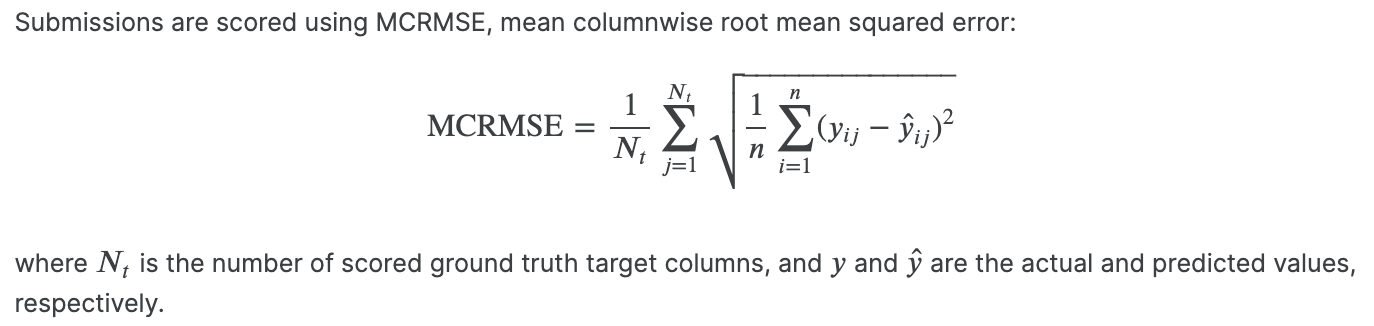

In [ ]:
def MCRMSE(y_true, y_pred):
  colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
  return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

# **Load Input Files**

In [ ]:
train_path = '/content/gdrive/MyDrive/Kaggle/train.csv'
test_path = '/content/gdrive/MyDrive/Kaggle/test.csv'

input_train_df = pd.read_csv(train_path)
input_test_df = pd.read_csv(test_path)

# input_train_df = pd.read_csv('train.csv')
# input_test_df = pd.read_csv('test.csv')

float_labels, int_map_labels = np.arange(1, 5.5, 0.5), np.arange(9)
label_map = dict(zip(float_labels, int_map_labels))

float_scaled_labels, int_scaled_labels = np.arange(1, 6, 1), np.arange(6)
label_scaled_map = dict(zip(float_scaled_labels, int_scaled_labels))

orig_train_df = copy.deepcopy(input_train_df)
orig_train_df.head()

"Map" columns are basically scaled columns of the original metric values. There are total 9 levels in map columns. Original mretric columns range from 1 to 5. Through map columns, they range from 0 to 8.

"Scaled" columns map numbers .5, 1.5, 2.5, 3.5 and 4.5 to nearset integers. Thus it will have range from 1 to 5.

# **Split Data** into **3 Dataframes**
- df_train
- df_val
- df_test

In [ ]:
shuffle = np.random.permutation(np.arange(orig_train_df.shape[0]))
orig_train_df = orig_train_df.iloc[shuffle]
split=(0.8,0.1,0.1)
splits = np.multiply(len(orig_train_df), split).astype(int)
df_train, df_val, df_test = np.split(orig_train_df, [splits[0], splits[0] + splits[1]])
df_train.head()

In [ ]:
label_cols = df_train.columns[2:]
print(label_cols)
label_rounded_cols = [col + '_rounded_val' for col in label_cols]
label_map_cols = [col + '_map' for col in label_cols]
cat_label_cols = get_cat_label_cols(label_cols)

df_train = apply_label_map(df_train, label_map, label_cols)
df_test = apply_label_map(df_test, label_map, label_cols)
df_val = apply_label_map(df_val, label_map, label_cols)

In [ ]:
label_cols, label_rounded_cols, label_map_cols, cat_label_cols

# **Addiung Other Feature Columns**

In [ ]:
df_train = add_feature(df_train)
df_test = add_feature(df_test)
df_val = add_feature(df_val)

# **EDA**

In [ ]:
df_train.head()

In [ ]:
for col in label_cols:
    print(df_train[col + '_rounded_val'].unique())

In [ ]:
df_train.iloc[0]

In [ ]:
df_test.head()

In [ ]:
df_val.head()

In [ ]:
df_train.shape, df_test.shape, df_val.shape

In [ ]:
df_train.describe()

In [ ]:
# df_train.columns

## **Unique Values for Each Label**

In [ ]:
# get_unique_values_for_labels(df_train, label_cols)

## **Unique Values for Each Rounded Label**

In [ ]:
# get_unique_values_for_labels(df_train, label_rounded_cols)

## **Value Counts for Each Label**

In [ ]:
# get_value_counts_for_labels(df_train, label_cols)

In [ ]:
# plot_count(df_train, label_cols)

## **Value Counts for Each Rounded Label**

In [ ]:
# get_value_counts_for_labels(df_train, label_rounded_cols)

In [ ]:
# plot_count(df_train, label_rounded_cols)

## **Full Text Length Stats**

In [ ]:
# df_train.full_text.str.len().describe()

## **Word Count Stats**

In [ ]:
# df_train.word_count.describe()

## **Sentence Count Stats**

In [ ]:
# df_train.sentence_count.describe()

In [ ]:
# df_train[df_train.sentence_count == 1][['full_text']]

# **Visualization**

## **Corelation Matrix of the Label Columns**

In [ ]:
# corr = df_train[label_cols].corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype = bool))

# sns.set(rc = {"figure.figsize": (10, 8)})

# sns.heatmap(corr, 
#             annot = True, 
#             cmap = "coolwarm", 
#             mask = mask,
#             fmt  = ".5f")
# plt.show()

## **Essay Length, Word Count, Total Score, Sentence Count Distribution**

Essay length, word count and sentence count diostributions have normal shape, though left skewed. Total score distribution looks bi-modal.

In [ ]:
# plt.figure(figsize=(20,5))

# plt.subplot(1,4,1)
# sns.histplot(data=df_train, x='word_count', kde=True)
# plt.axvline(x=df_train['word_count'].mean(),color='red')
# plt.axvline(x=df_train['word_count'].median(),color='black')
# plt.xlabel('Word Count Distribution',fontsize=12)
# plt.title('Word Count Distribution',fontsize=16)

# plt.subplot(1,4,2)
# sns.histplot(data=df_train, x='full_text_len', kde=True)
# plt.axvline(x=df_train['full_text_len'].mean(),color='red')
# plt.axvline(x=df_train['full_text_len'].median(),color='black')
# plt.xlabel('Full Text Length Distribution',fontsize=12)
# plt.title('Full Text Length Distribution',fontsize=16)

# plt.subplot(1,4,3)
# sns.histplot(data=df_train, x='total_score', kde=True)
# plt.axvline(x=df_train['total_score'].mean(),color='red')
# plt.axvline(x=df_train['total_score'].median(),color='black')
# plt.xlabel('Total Score Distribution',fontsize=12)
# plt.title('Total Score Distribution',fontsize=16)

# plt.subplot(1,4,4)
# sns.histplot(data=df_train, x='sentence_count', kde=True)
# plt.axvline(x=df_train['sentence_count'].mean(),color='red')
# plt.axvline(x=df_train['sentence_count'].median(),color='black')
# plt.xlabel('Sentence Count Distribution',fontsize=12)
# plt.title('Sentence Count Distribution',fontsize=16)

## **Word Count Vs Individual Label Scores**

In [ ]:
# get_histogram_for_col(df_train, label_cols, 'word_count')

## **Word Count Vs Individual Rounded Label Scores**

In [ ]:
# get_histogram_for_col(df_train, label_rounded_cols, 'word_count')

## **Sentence Count Vs Individual Label Scores**

In [ ]:
# get_histogram_for_col(df_train, label_cols, 'sentence_count')

## **Sentence Count Vs Individual Rounded Label Scores**

In [ ]:
# get_histogram_for_col(df_train, label_rounded_cols, 'sentence_count')

## **Distribution of Labels Above and Below Average in the Respective Category**

In [ ]:
# get_count_plot_for_ind_col(df_train, '_above_or_below_avg_flag', label_cols)

## **Distribution of Labels Above and Below Median in the Respective Category**

In [ ]:
# get_count_plot_for_ind_col(df_train, '_above_or_below_median_flag', label_cols)

For all the labels we see that most of the label values are below average and median values.

## **Distribution of Labels**

In [ ]:
# fig, ax = plt.subplots(1, len(label_cols), figsize=(40,10))

# for idx, label in enumerate(label_cols):
#     sns.distplot(x = df_train[label],
#                  ax = ax[idx]
#                 )
#     ax[idx].set_title(label)
#     #plt.show(block = False)

## **Average Score Per Label**

In [ ]:
# get_barplot_for_each_label(df_train, label_cols, '_avg_score')

## **Median Score Per Label**

In [ ]:
# get_barplot_for_each_label(df_train, label_cols, '_median_score')

## **Most Frequent Words**

In [ ]:
# text = df_train[df_train[label_cols].sum(axis=1)==30]['full_text'].values[0]
# word_cloud = WordCloud(stopwords=STOPWORDS, colormap='Pastel1', collocations=False, width=1200, height=700, background_color = "black").generate(text)
# plt.figure(figsize=(20,8))
# plt.imshow(word_cloud)
# plt.axis("off")
# plt.show()
     

# **Regression** Model with **BERT**



## Model Checkpoint and **Tokenization** from Pre-trained BERT

In [ ]:
from transformers import BertTokenizer, TFBertModel

#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'   # case sensitive (care about upper and lower case)
bert_model = TFBertModel.from_pretrained(model_checkpoint)  
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

In [ ]:
bert_model.config

In [ ]:
# for layer in bert_model.weights:
#     print(layer.name, layer.trainable)

## **Split Data** into **X and Y**


In [ ]:
X_train, X_val, X_test = df_train['full_text'], df_val['full_text'], df_test['full_text']
y_train, y_val, y_test = np.array(df_train[label_cols]), np.array(df_val[label_cols]), np.array(df_test[label_cols])

## **Generate Input Embeddings** - Train/Validation/Test Set

In [ ]:
MAX_LENGTH = 512

In [ ]:
train_encodings = bert_tokenizer(X_train.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
val_encodings = bert_tokenizer(X_val.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
test_encodings = bert_tokenizer(X_test.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')

## **Run Experiments**

In [ ]:
def run_regression_experiment(num_train_layers=0,
                              num_hidden_layer=1,
                              num_hidden_units=256,
                              dropout=0.3,
                              learning_rate=0.00005,
                              batch_size=8,
                              csv_filename='perf_summary_regression_w_BERT.csv',
                              activation = 'relu',                                    # 'relu', 'leaky_relu', 'gelu'
                              optimizer='adam',                                       # 'adam', 'sgd'
                              epochs=10):

  df_perf_summary = pd.DataFrame()
  for layer in num_train_layers:  
    print('\n******************************************************')
    print(f'Regression with BERT: Number of Unfrozen Layers = {layer}')
    print('******************************************************\n')


    # build a regression model
    regression_with_bert, num_trainable_params, num_non_trainable_params = regression_model_with_bert(num_classes = 9,                          # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                                                                                                      num_train_layers = layer,
                                                                                                      num_hidden_layer = num_hidden_layer,
                                                                                                      num_hidden_units = num_hidden_units,
                                                                                                      dropout = dropout,
                                                                                                      learning_rate = learning_rate,
                                                                                                      activation = activation,
                                                                                                      optimizer=optimizer)
    # print(f'Parameter Values:\n======================\nnum_hidden_layer = {num_hidden_layer}\nnum_hidden_units = {num_hidden_units}\ndropout = {dropout}\nlearning_rate = {learning_rate}\nbatch_size = {batch_size}\n')
    
    # model summary and plot model structure
    display(regression_with_bert.summary())
    display(keras.utils.plot_model(regression_with_bert, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

    # train model
    df_regression_model_history = train_regression(regression_with_bert, batch_size, epochs)
    print("\nPlotting loss and MCRMSE...")
    plot_loss_mcrmse(df_regression_model_history, 'MCRMSE')  
    # print("\nTensorBoard: Evolution of Loss and MCRMSE:\n=============================================")
    # %tensorboard --logdir logs/fit

    # Evaluate test set
    score_regression = evaluate_test_labels(regression_with_bert)

    # Predict test set
    df_pred = predict_test_labels(regression_with_bert)
    df_pred_scaled = scaled_pred(df_pred)
    
    # Create a final table with y_true, y_pred_raw, and y_pred_scaled
    # display(generate_final_table(df_pred))

    # ========== Performace metrics summary ===================================
    perf_metrics = pd.DataFrame({'NLP Model':"bert-base-cased",
                                'Num_Trainable_layers': layer,
                                # 'Trainable_Params':  f'{num_trainable_params:,}',
                                # 'Non-Trainable_Params':  f'{num_non_trainable_params:,}',
                                'Epochs':epochs,                                                              
                                'Test_MCRMSE':round(score_regression[1], 4), 
                                'Test_Loss':round(score_regression[0], 4), 
                                'Train_MCRMSE':round(df_regression_model_history.iloc[-1][1], 4), 
                                'Train_Loss':round(df_regression_model_history.iloc[-1][0], 4), 
                                'Val_MCRMSE':round(df_regression_model_history.iloc[-1][3], 4), 
                                'Val_Loss':round(df_regression_model_history.iloc[-1][2], 4),  
                                'Optimizer': optimizer, 
                                'Activation': activation,  
                                'Learning_Rate':learning_rate,                               
                                'Num_Hidden_Layers':num_hidden_layer, 
                                'Num_hidden_Units':num_hidden_units,                                 
                                'Dropout': dropout, 
                                'Batch_Size': batch_size}, index=[0])
    df_perf_summary = df_perf_summary.append(perf_metrics)
  df_perf_summary.to_csv(csv_filename, index=False)
  display(df_perf_summary.reset_index(drop=True))


In [ ]:
def run_regression_experiment_1(num_train_layers=0,
                              num_hidden_layer=1,
                              num_hidden_units=256,
                              dropout=0.3,
                              learning_rate=0.00005,
                              batch_size=8,
                              csv_filename='perf_summary_regression_w_BERT.csv',
                              activation = 'relu',                                    # 'relu', 'leaky_relu', 'gelu'
                              optimizer='adam',                                       # 'adam', 'sgd'
                              epochs=10):

  # df_perf_summary = pd.DataFrame()
  # for layer in num_train_layers:  
  print('\n******************************************************')
  print(f'Regression with BERT: Number of Unfrozen Layers = {num_train_layers}')
  print('******************************************************\n')


  # build a regression model
  regression_with_bert, num_trainable_params, num_non_trainable_params = regression_model_with_bert(num_classes = 9,                          # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                                                                                                    num_train_layers = num_train_layers,
                                                                                                    num_hidden_layer = num_hidden_layer,
                                                                                                    num_hidden_units = num_hidden_units,
                                                                                                    dropout = dropout,
                                                                                                    learning_rate = learning_rate,
                                                                                                    activation = activation,
                                                                                                    optimizer=optimizer)
  # print(f'Parameter Values:\n======================\nnum_hidden_layer = {num_hidden_layer}\nnum_hidden_units = {num_hidden_units}\ndropout = {dropout}\nlearning_rate = {learning_rate}\nbatch_size = {batch_size}\n')
  
  # model summary and plot model structure
  display(regression_with_bert.summary())
  display(keras.utils.plot_model(regression_with_bert, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

  # train model
  df_regression_model_history = train_regression(regression_with_bert, batch_size, epochs)
  print("\nPlotting loss and MCRMSE...")
  plot_loss_mcrmse(df_regression_model_history, 'MCRMSE')  
  # print("\nTensorBoard: Evolution of Loss and MCRMSE:\n=============================================")
  # %tensorboard --logdir logs/fit

  # Evaluate test set
  score_regression = evaluate_test_labels(regression_with_bert)

  # Predict test set
  df_pred = predict_test_labels(regression_with_bert)
  df_pred_scaled = scaled_pred(df_pred)
  df_pred.to_csv('df_pred.csv', index=False)
  
  # Create a final table with y_true, y_pred_raw, and y_pred_scaled
  df_final = generate_final_table(df_pred)
  display(generate_final_table(df_pred))
  df_final.to_csv('df_final.csv', index=False)

  # ========== Performace metrics summary ===================================
  perf_metrics = pd.DataFrame({'NLP Model':"bert-base-cased",
                              'Num_Trainable_layers': num_train_layers,
                              # 'Trainable_Params':  f'{num_trainable_params:,}',
                              # 'Non-Trainable_Params':  f'{num_non_trainable_params:,}',
                              'Epochs':epochs,                                                              
                              'Test_MCRMSE':round(score_regression[1], 4), 
                              'Test_Loss':round(score_regression[0], 4), 
                              'Train_MCRMSE':round(df_regression_model_history.iloc[-1][1], 4), 
                              'Train_Loss':round(df_regression_model_history.iloc[-1][0], 4), 
                              'Val_MCRMSE':round(df_regression_model_history.iloc[-1][3], 4), 
                              'Val_Loss':round(df_regression_model_history.iloc[-1][2], 4),  
                              'Optimizer': optimizer, 
                              'Activation': activation,  
                              'Learning_Rate':learning_rate,                               
                              'Num_Hidden_Layers':num_hidden_layer, 
                              'Num_hidden_Units':num_hidden_units,                                 
                              'Dropout': dropout, 
                              'Batch_Size': batch_size}, index=[0])
    # df_perf_summary = df_perf_summary.append(perf_metrics)
  perf_metrics.to_csv(csv_filename, index=False)
  display(perf_metrics.reset_index(drop=True))


## **Build Regression Model with BERT**

In [ ]:
def regression_model_with_bert(num_classes=9,                  # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                               num_train_layers=0,
                               num_hidden_layer=1,
                               num_hidden_units=256,
                               dropout=0.3,
                               learning_rate=0.00005,
                               activation = 'relu',
                               optimizer='adam'):
    """
    Build a simple regression model with BERT. Use the CLS Output for regression purposes.
    """
    # =========== BEGIN generate "input features" using pre-trained model tokenizer ==================================
    if num_train_layers == 0:
        bert_model.trainable = False                 # Freeze all layers of pre-trained BERT model

    elif num_train_layers == 12:         
        bert_model.trainable = True                  # Train all layers of the BERT model

    else:                                            # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code) 
        # print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False
    
    # Input Layer
    input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_LENGTH), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'attention_mask': attention_mask
                  }
                      
    # Bert output: being used as an input feature in the classification model below
    bert_out = bert_model(bert_inputs)        # full features as an input to the following classification model
    # pooler_output = bert_out[1]             # one vector for each
    cls_token = bert_out[0][:, 0, :]          # give us a raw CLS tokens


    layer_list = []
    for hidden_layer_number in range(num_hidden_layer):
        if hidden_layer_number == 0:
            hidden_layer = tf.keras.layers.Dense(units = num_hidden_units
                                        , activation = activation
                                        , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                        )(cls_token)
        else:
            hidden_layer = tf.keras.layers.Dense(units = num_hidden_units
                                        , activation = activation
                                        , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                        )(layer_list[-1])
        layer_list.append(hidden_layer)
        dropout_layer = tf.keras.layers.Dropout(dropout, name = 'dropout_layer_' + str(hidden_layer_number + 1))(hidden_layer) 
        layer_list.append(dropout_layer)

    output = tf.keras.layers.Dense(6,)(layer_list[-1])
    regression_model = tf.keras.Model(inputs = [input_ids, attention_mask], outputs = output)    

    def selected_optimizer(optimizer):
      if optimizer.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)           
      elif optimizer.lower() == 'adam':
        return Adam(learning_rate=learning_rate)          

    regression_model.compile(optimizer = selected_optimizer(optimizer),
                             loss=MCRMSE,
                             metrics=MCRMSE) 

    return regression_model, count_params(regression_model.trainable_weights), count_params(regression_model.non_trainable_weights)

## Set up a TensorBoard
[Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started#:~:text=TensorBoard%20is%20a%20tool%20for,dimensional%20space%2C%20and%20much%20more)

In [ ]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

In [ ]:
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [ ]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Train the Regression Model with:
- **Early Stopping callback** - Stop training when start overfitting
- **Model Checkpoint callback** - Save the model output in the temp folder (Model_Checkpoint) created in Google Drive. Whenever you re-run your model, the existing logs will be replaced with the output of new run.
- **Tensorboard callback** - Display the loss and MCRMSE evolution

We want to run until val_loss started increasing and over passing the training loss (overfitting). That's where the right number of epochs we need to have to run the model. To control this, we set up the Early Stopping callback.

In [ ]:
# batch_size = random.choice([8,16])
def train_regression(model, batch_size, epochs):  
  checkpoint_filepath = '/content/gdrive/MyDrive/Kaggle/Model_Checkpoint/'         #  Create a new directory, Model_Checkpoint, in my Google Drive first and navigate the path here
  checkpoint_filepath = checkpoint_filepath + 'weights.{epoch:02d}-{val_MCRMSE:.2f}.hdf5'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                  monitor='val_loss',
                                                                  mode='min',
                                                                  save_weights_only=True,
                                                                  save_best_only=True)  
  # The following parameters say: "If there hasn't been at least an improvement of 0.001 in the validation loss over the previous 3 epochs, then stop the training and keep the best model you found."
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                              min_delta=0.001, # minimium amount of change to count as an improvement
                                              patience=3,      # how many epochs to wait before stopping
                                              restore_best_weights=True)

  print('Training Regression with BERT.....\n====================================='  )
  regression_model_history = model.fit([train_encodings.input_ids, 
                                        train_encodings.attention_mask
                                        ], 
                                        y_train,   
                                        validation_data =([val_encodings.input_ids, 
                                                            val_encodings.attention_mask], 
                                                          y_val
                                                          ),    
                                        batch_size = batch_size, 
                                        # callbacks=[callback, model_checkpoint_callback, tensorboard_callback],
                                        callbacks=[early_stopping_callback, model_checkpoint_callback],
                                        epochs = epochs 
                                        # verbose=0    # make output invisible
                                        )    
  df_regression_model_history = pd.DataFrame(regression_model_history.history)
  display(df_regression_model_history.T)     
  return df_regression_model_history                                       

In [ ]:
def plot_loss_mcrmse(df, eval_metric):
    x_arr = np.arange(len(df['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, df['loss'], '-o', label = 'Train Loss')
    ax.plot(x_arr, df['val_loss'], '--<', label = 'Validation Loss')
    ax.legend(fontsize = 12)
    ax.set_xlabel('Epoch', size = 12)
    ax.set_ylabel('Loss', size = 12)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, df[eval_metric], '-o', label = 'Train ' + eval_metric)
    ax.plot(x_arr, df['val_' + eval_metric], '--<', label = 'Validation ' + eval_metric)
    ax.legend(fontsize = 12)
    ax.set_xlabel('Epoch', size = 12)
    ax.set_ylabel('MCRMSE', size = 12)
    #ax.set_ylim(0,1)
    plt.show()

## Evaluate Test Set

In [ ]:
def evaluate_test_labels(model):
  score_regression = model.evaluate([test_encodings.input_ids, 
                                          test_encodings.attention_mask
                                          ], 
                                          y_test
                                          ) 
  print('\nEvaluate Test Metrics:\n=================================')
  print('\nTest loss: {:.4f}'.format(score_regression[0]))
  print('\nTest MCRMSE score: {:.4f}'.format(score_regression[1]),'\n')
  return score_regression

## Predict Scores for 6 Metrics in Test Set

In [ ]:
def predict_test_labels(model):
  predictions = model.predict([test_encodings.input_ids, test_encodings.attention_mask])    # -1 in reshape function is used when you don't know or want to explicitly tell the dimension of that axis.
  df_pred = pd.DataFrame(predictions, columns=['pred_'+ col for col in label_cols])
  return df_pred

## Final Output Table:
- True Scores of Test Set
- Raw Predicted Scores of Test Set 
- Scaled Predicted Scores of Test Set 

In [ ]:
def scaled_pred(df):
  pred_scaled = []
  for col in df:
    df[col + '_scaled'] = df[col].apply(lambda val: round(val/0.5) * 0.5)  # Round up the raw prediction score to be comparable
    pred_scaled.append(df[col + '_scaled'])
  return pd.DataFrame(pred_scaled).T

In [ ]:
def generate_final_table(df_pred):
  # print('\nFinal Table: y_true vs. y_pred_raw vs. y_pred_scaled\n======================================================')
  df_final = pd.concat([df_test[['full_text']].reset_index(drop=True), df_test[label_cols].reset_index(drop=True), df_pred], axis=1)
  # display(df_final)
  return df_final

## **Experiment** - Regression with BERT

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,6),
                          activation='relu',
                          optimizer='adam',                          
                          csv_filename='perf_summary_regression_w_BERT_1.csv')

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,2),
                          num_hidden_layer=2,
                          num_hidden_units=64,
                          dropout=0.1,
                          learning_rate=0.00001,
                          batch_size=16,
                          csv_filename='perf_summary_regression_w_BERT_2.csv',
                          activation='relu',
                          optimizer='adam',
                          epochs=10)

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,2),
                          csv_filename='perf_summary_regression_w_BERT_5.csv')

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,6),
                          batch_size=16,
                          activation='relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_4.csv')

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,6),
                          batch_size=16,
                          activation='gelu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_gelu.csv')

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,7,2),
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu.csv')

In [ ]:
run_regression_experiment(num_train_layers=np.arange(2,5,2),
                          dropout=0.1,
                          batch_size=16,
                          activation='relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu.csv')

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,7,2),
                          dropout=0.2,
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu_sgd.csv')

In [ ]:
 run_regression_experiment(num_train_layers=np.arange(0,7,2),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          dropout=0.2,
                          learning_rate=0.0001,
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu_lowerLR.csv')

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,4),
                          # num_hidden_layer=1,
                          num_hidden_units=128,
                          dropout=0.2,
                          learning_rate=0.0005,
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu_lowerLR2.csv')

In [ ]:
 run_regression_experiment(num_train_layers=np.arange(0,13,4),
                          # num_hidden_layer=1,
                          num_hidden_units=64,
                          dropout=0.2,
                          learning_rate=0.0005,
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu_lowerLR128.csv')


In [ ]:
run_regression_experiment_1(num_train_layers=12,
                          num_hidden_layer=2,
                          num_hidden_units=64,
                          dropout=0.1,
                          learning_rate=0.00001,
                          batch_size=8,               # from 16 to 8: no more OOM error
                          csv_filename='perf_summary_regression_w_BERT_final1.csv',
                          activation='relu',
                          optimizer='adam',
                          epochs=10)

In [ ]:
run_regression_experiment_1(num_train_layers=12,
                          num_hidden_layer=2,
                          num_hidden_units=64,
                          dropout=0.1,
                          learning_rate=0.00001,
                          batch_size=8,               # from 16 to 8: no more OOM error
                          csv_filename='perf_summary_regression_w_BERT_final1.csv',
                          activation='relu',
                          optimizer='adam',
                          epochs=10)

In [ ]:
run_regression_experiment_1(num_train_layers=12,
                          num_hidden_layer=2,
                          num_hidden_units=64,
                          dropout=0.1,
                          learning_rate=0.00001,
                          batch_size=8,               # from 16 to 8: no more OOM error
                          csv_filename='perf_summary_regression_w_BERT_final2.csv',
                          activation='leaky_relu',
                          optimizer='adam',
                          epochs=10)

In [ ]:
run_regression_experiment_1(num_train_layers=12,
                          num_hidden_layer=2,
                          num_hidden_units=64,
                          dropout=0.1,
                          learning_rate=0.00001,
                          batch_size=8,               # from 16 to 8: no more OOM error
                          csv_filename='perf_summary_regression_w_BERT_final3.csv',
                          activation='gelu',
                          optimizer='adam',
                          epochs=10)